# Enobio Solid Gels
Use this notebook to look through the data collected using the solid gel electrodes with the Neuroelectrics Enobio device. A large portion of this code was originally written by Tara Sirosh (high school intern) for investigating DMN activity recorded with the DSI-7 device. Code adapted for the Enobio and notebook written by Nile Wilson (2018.12.17).

In [1]:
from matplotlib import pyplot as plt
import scipy.signal as scisig
import numpy as np
import pandas as pd
import csv

Function to convert .easy files from NIC2 (recording software for Enobio) to Pandas dataframe

In [2]:
def ConvertEasyToDataFrame(filename):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    # Read in the .easy file
    df = pd.read_csv(filename, delimiter='\t', header=None)
    
    # Get metadata from the .info file
    fname = filename[:-5] + '.info'
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Get the channel names
    channel_info = [x for x in content if 'Channel ' in x]
    channel_names = []
    for ch in range(len(channel_info)):
        channel_names.append(channel_info[ch].split(': ')[1])
        
    channel_names.append('X')
    channel_names.append('Y')
    channel_names.append('Z')
    channel_names.append('STI 014')
    channel_names.append('DateTime')
    
    # Get sampling rates
    sampling_rates = [x for x in content if 'sampling rate: ' in x]
    fs_all = []
    for freq in range(len(sampling_rates)):
        fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

    # Store sampling rates
    fs = fs_all[0]
    fs_accel = fs_all[1]
    
    # Assign the column names
    df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

## Load the EEG data
Load in the data from the NIC2 .easy file and convert to a Pandas dataframe

In [3]:
filename = '../data/20181214143329_Patient01_Collect Data.easy'
EEGdata, fs, fs_accel = ConvertEasyToDataFrame(filename)

In [4]:
# Preview
EEGdata.head()

,Fz,Cz,P3,P4,Pz,O1,O2,Oz,X,Y,Z,STI 014,DateTime
0,-33303789,-22180607,-33301738,-22397806,-390333555,-27792838,-37343840,-42089848,0,0,0,0,1544826808984
1,-33155492,-22103407,-33170322,-22198632,-390220927,-27781108,-37277750,-41953377,0,0,0,0,1544826808986
2,-33060506,-22057392,-33084825,-22080757,-390150641,-27767566,-37228159,-41866212,0,0,0,0,1544826808988
3,-33123211,-22100355,-33139280,-22172310,-390202759,-27773574,-37255243,-41921906,0,0,0,0,1544826808990
4,-33294967,-22200682,-33292631,-22399475,-390339993,-27792981,-37339787,-42079692,0,0,0,0,1544826808992


In [5]:
np.shape(EEGdata)

(742069, 13)

In [6]:
# Create the time array
time = np.linspace(0, np.shape(EEGdata)[0]/fs, np.shape(EEGdata)[0])

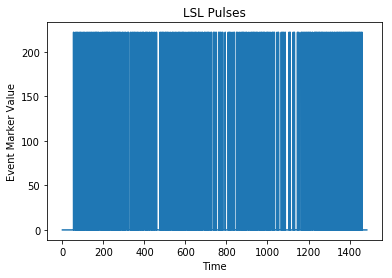

In [7]:
# Plot
plt.figure()
plt.plot(time, EEGdata['STI 014'])
plt.xlabel('Time')
plt.ylabel('Event Marker Value')
plt.title('LSL Pulses')
plt.show()

In [8]:
# Check pulse value(s)
np.unique(EEGdata['STI 014'])

array([  0, 222], dtype=int64)

In [9]:
np.shape(np.where(EEGdata['STI 014']==222))

(1, 200)

In [10]:
np.shape(np.where(EEGdata['STI 014']==111))

(1, 0)

Plot all channel data

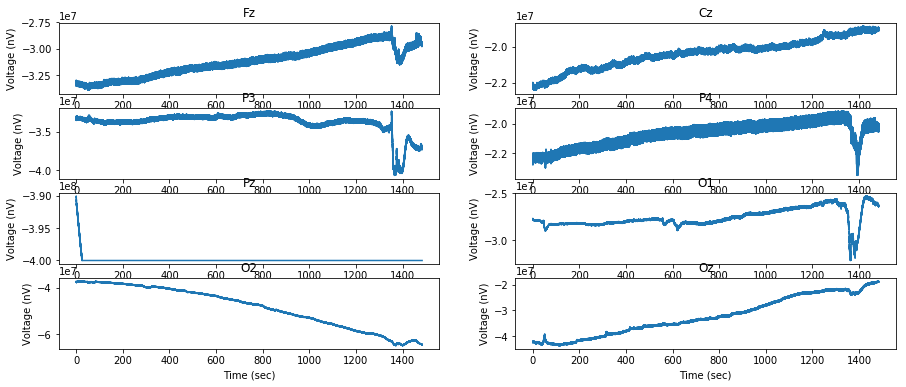

In [11]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
for chanOfInt in EEGdata.columns[:-5]:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

Plot accelerometer data

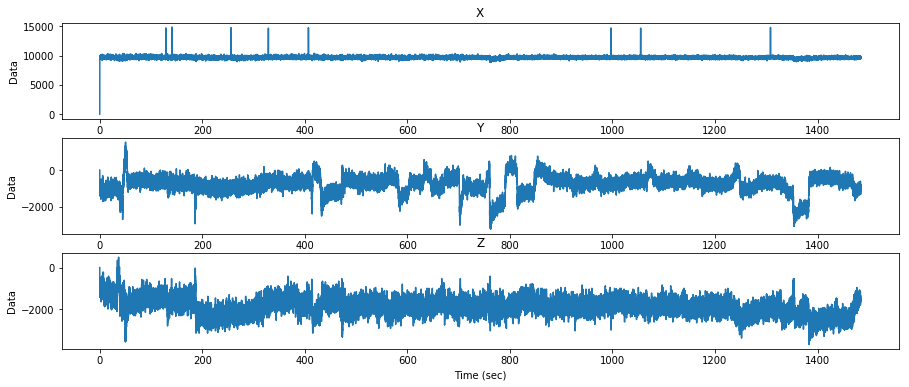

In [12]:
fig, axs = plt.subplots(3,1, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
for chanOfInt in EEGdata.columns[-5:-2]:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Data')
    axs[i].set_title(chanOfInt)
    i += 1

Plot event marker data

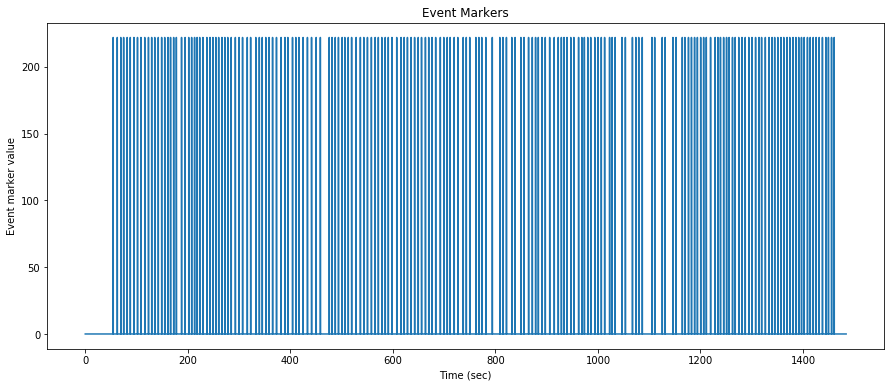

In [13]:
plt.figure(figsize=(15,6))
plt.plot(time, EEGdata['STI 014'])
plt.xlabel('Time (sec)')
plt.ylabel('Event marker value')
plt.title('Event Markers')
plt.show()

## Load the behavioral data

In [14]:
behavioral_file = '../data/nile_DMN_R1.csv'
behavioralData = pd.read_csv(behavioral_file, ',')
behavioralData = behavioralData.transpose()

# Saving header information
behavioralHeader = behavioralData.iloc[0]

behavioralData = behavioralData.iloc[2:]
behavioralData.columns = behavioralHeader
behavioralData.head()

Unnamed: 0,trialStart,stimulus,key,RT,blockType
trial_0,17.814141371473625,I am shy,true,2.114040056296062,C
trial_1,25.811097436015643,I am funny,false,0.8532433977129585,C
trial_2,32.59674383388665,I am smart,false,0.8990189132332489,C
trial_3,38.204081920009,I am easily frustrated,false,0.9177817416355083,C
trial_4,45.10521161943643,I am very observant,true,1.7008674192022681,C


### Sync up event markers / trigger pulses
Note that for the DSI-7, we sound audio beeps that are sent as pulses through the trigger hub and are recorded with the EEG. For the Enobio, we use Lab Streaming Layer (LSL) to send direct pulses with integer values to the recording software.

In [15]:
# Store where the values in trigger are equal to 222 (the value sent for trial starts)
index_trigger = np.where(EEGdata['STI 014']==222)
np.shape(index_trigger)

(1, 200)

Get the trial and rest start and end times

In [16]:
# Get trial timing
t_trial_start = list()
t_trial_end = list()

# Check number of trials
num_of_trials = behavioralData.shape[0]

# Creating lists of all trigger start and end locations
for i in range(0,num_of_trials):
    t_trial_start.append(index_trigger[0][i])
    t_trial_end.append(index_trigger[0][i] + int(float(behavioralData['RT'][i])*fs))

# Save rest period epochs as well as trials for comparison
t_rest_start = list()
t_rest_end = list()

for i in range(num_of_trials-1):
    t_rest_start.append(t_trial_end[i])
    t_rest_end.append(t_trial_start[i+1])

## Cleaning the EEG data
Artifact removal and filtering

In [17]:
from mne.filter import filter_data

In [18]:
EEGdata_filt = EEGdata.copy()
channels = EEGdata.columns[0:8]

eeg_data = EEGdata[channels].values * 1.0 # multiply by 1.0 to convert int to float
filtered = filter_data(eeg_data.T, sfreq=fs, l_freq=1, h_freq=40)
EEGdata_filt[channels] = filtered.T

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


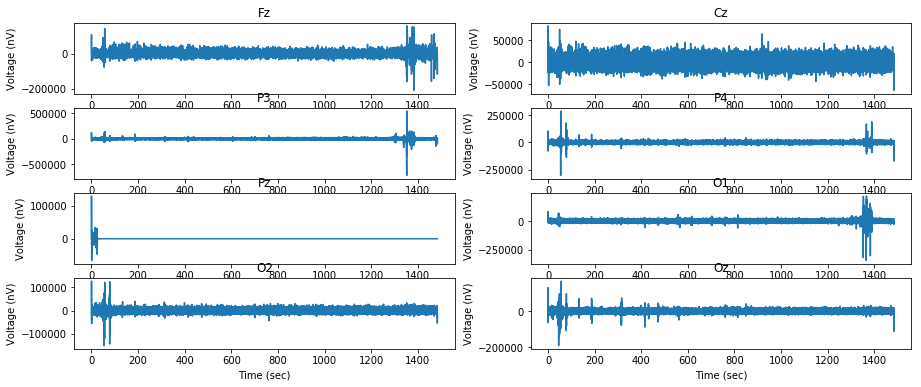

In [19]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[0:8]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata_filt[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

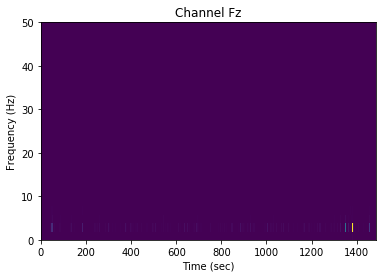

In [20]:
chanOfInt = 'Fz'
f, t, Sxx = scisig.spectrogram(EEGdata_filt[chanOfInt], fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0,50])
plt.title('Channel ' + chanOfInt)
plt.show()

In [21]:
f

array([  0.      ,   1.953125,   3.90625 ,   5.859375,   7.8125  ,
         9.765625,  11.71875 ,  13.671875,  15.625   ,  17.578125,
        19.53125 ,  21.484375,  23.4375  ,  25.390625,  27.34375 ,
        29.296875,  31.25    ,  33.203125,  35.15625 ,  37.109375,
        39.0625  ,  41.015625,  42.96875 ,  44.921875,  46.875   ,
        48.828125,  50.78125 ,  52.734375,  54.6875  ,  56.640625,
        58.59375 ,  60.546875,  62.5     ,  64.453125,  66.40625 ,
        68.359375,  70.3125  ,  72.265625,  74.21875 ,  76.171875,
        78.125   ,  80.078125,  82.03125 ,  83.984375,  85.9375  ,
        87.890625,  89.84375 ,  91.796875,  93.75    ,  95.703125,
        97.65625 ,  99.609375, 101.5625  , 103.515625, 105.46875 ,
       107.421875, 109.375   , 111.328125, 113.28125 , 115.234375,
       117.1875  , 119.140625, 121.09375 , 123.046875, 125.      ,
       126.953125, 128.90625 , 130.859375, 132.8125  , 134.765625,
       136.71875 , 138.671875, 140.625   , 142.578125, 144.531

## Epoch and visualize the data
Separate the data by trials (cleaned "raw" data and frequency information) and visually inspect the time-frequency information for the trial conditions. Does power in any particular band look consistently different for math vs non-math trials?

In [22]:
epochs_raw = []
epochs_filt = []

for trial in range(0,len(t_trial_start)):
    epochs_raw.append(EEGdata.loc[t_trial_start[trial]:t_trial_end[trial]][channels])
    epochs_filt.append(EEGdata_filt.loc[t_trial_start[trial]:t_trial_end[trial]][channels])

In [23]:
# This ends up returning a list of dataframes where df[trial number][channels]
epochs_raw[0].head()

,Fz,Cz,P3,P4,Pz,O1,O2,Oz
27238,-33823684,-22202637,-33381799,-22612288,-400000047,-28982356,-37854437,-41542105
27239,-33819536,-22189476,-33378891,-22606327,-400000047,-28978446,-37853007,-41539387
27240,-33738283,-22138741,-33306793,-22499134,-400000047,-28967956,-37816862,-41466002
27241,-33610014,-22065785,-33190969,-22332241,-400000047,-28946784,-37753872,-41347365
27242,-33453659,-21984389,-33049205,-22129729,-400000047,-28924420,-37678007,-41200785


In [24]:
# See how many trials we have
len(epochs_raw)

200

A useful link on spectrogram settings https://stackoverflow.com/questions/43353172/producing-spectrogram-from-microphone/43454643

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


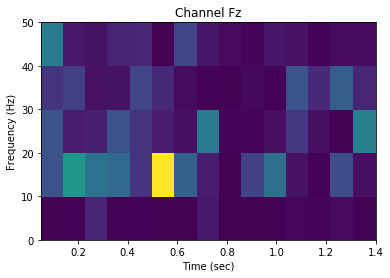

In [25]:
chanOfInt = 'Fz'
trialOfInt = 15

ds_factor = 5 # downsampling factor
f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)
#f, t, Sxx = scisig.spectrogram(epochs_raw[trialOfInt][chanOfInt], fs, nperseg=10)

# nperseg determines size of time bins, number of time bins = fs/nperseg - 1

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
#plt.ylim([0,50])
plt.title('Channel ' + chanOfInt)
plt.show()

## Organize by trial type
Create lists containing trial numbers for math and non-math trials

In [26]:
blockA = list()
blockB = list()
blockC = list()
blockD = list()
blockE = list()
i = 0

for letter in behavioralData['blockType']:
    if letter == 'A':
        blockA.append(i)
    elif letter == 'B':
        blockB.append(i)
    elif letter == 'C':
        blockC.append(i)
    elif letter == 'D':
        blockD.append(i)
    elif letter == 'E':
        blockE.append(i)
    i += 1

print(blockA)

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [27]:
# 1 = math, 0 = not math
trial_type = list()
blockE_math = [80, 81, 82, 85, 90, 92, 93, 94, 96, 98, 120, 121, 127, 128, 129, 130, 131, 133, 134, 138]
i = 0

for letter in behavioralData['blockType']:
    if letter == 'B' or letter == 'C' or letter == 'D':
        trial_type.append(0)
    elif letter == 'A':
        trial_type.append(1)
    elif letter == 'E':
        if i in blockE_math:
            trial_type.append(1)
        else:
            trial_type.append(0)
    i += 1

In [28]:
np.shape(trial_type)

(200,)

## Compare the data
Compare the alpha and beta power in certain electrode locations to see if we see what we expect regarding DMN activity

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


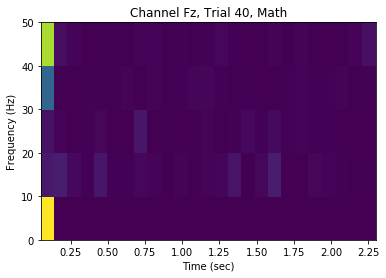

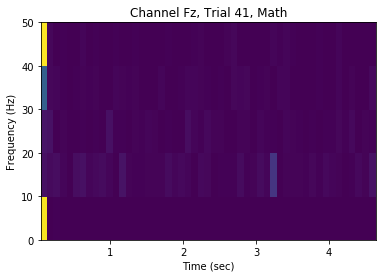

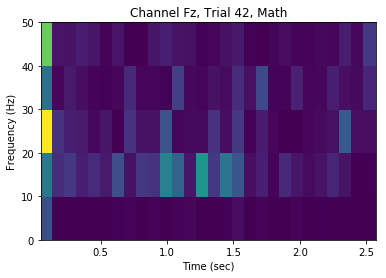

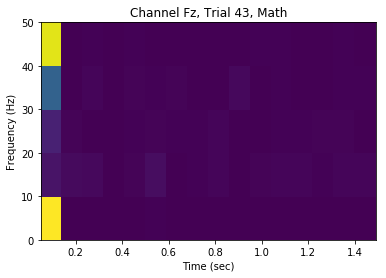

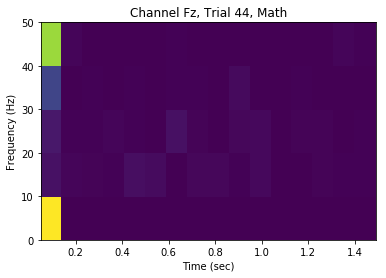

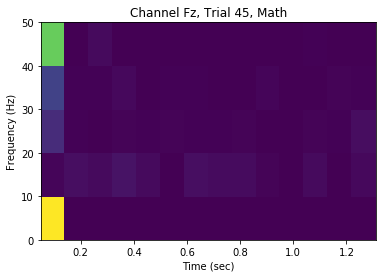

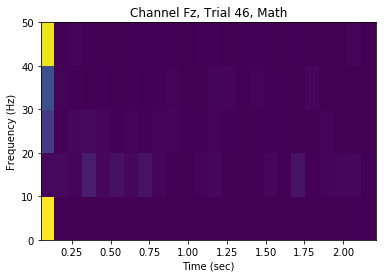

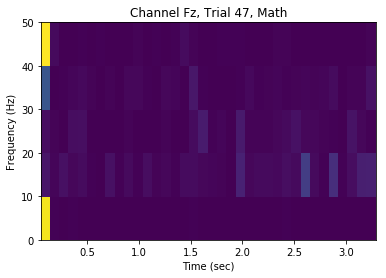

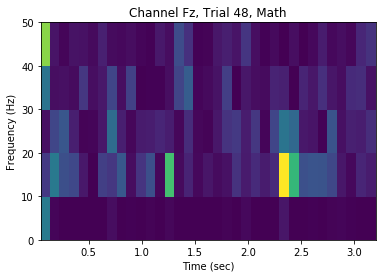

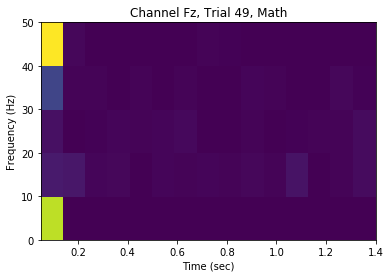

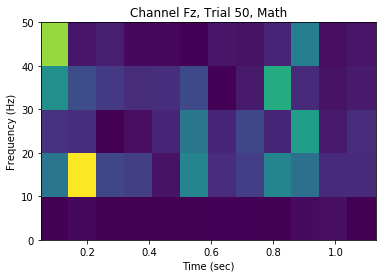

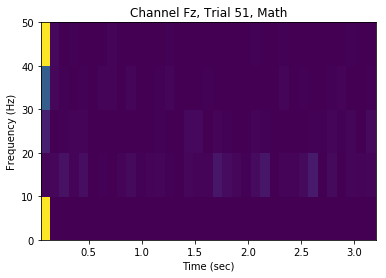

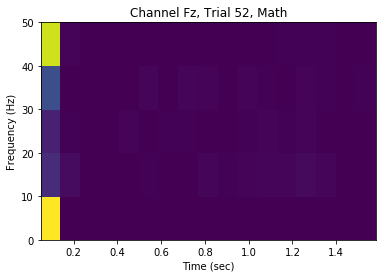

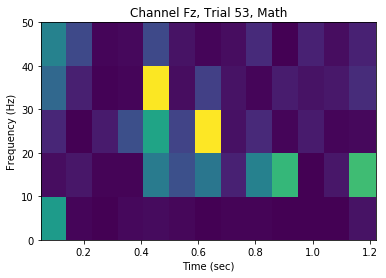

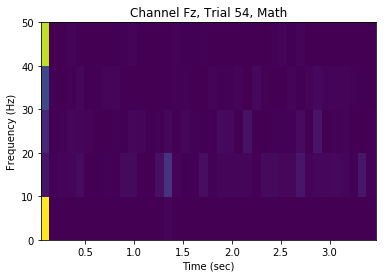

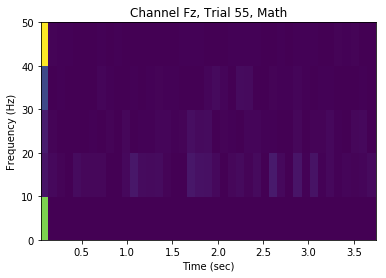

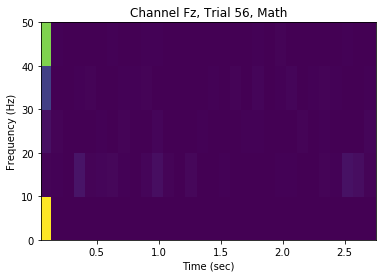

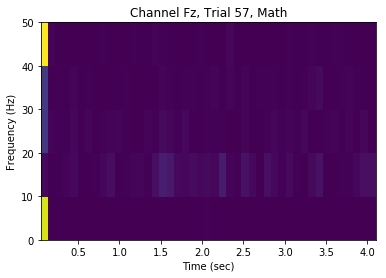

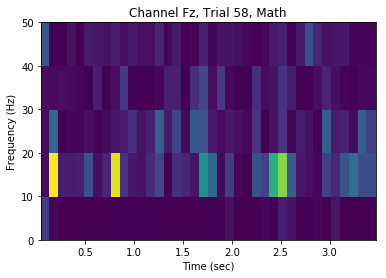

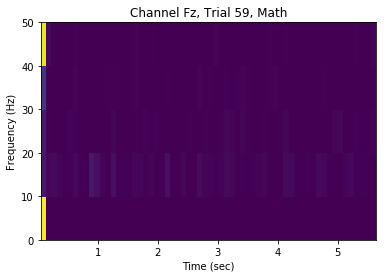

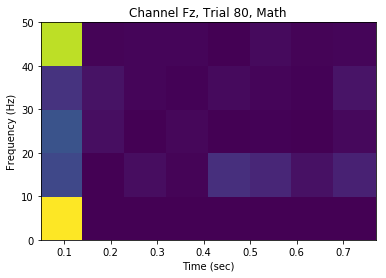

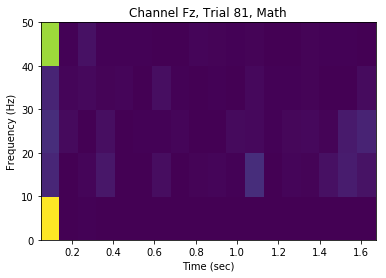

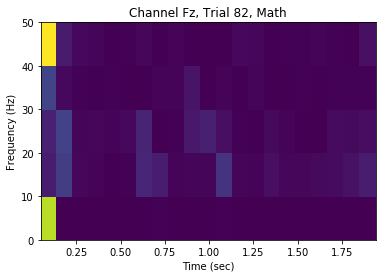

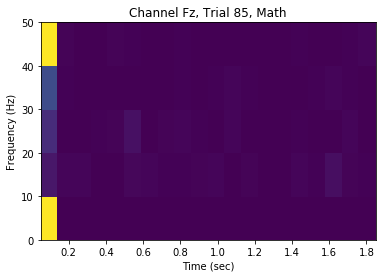

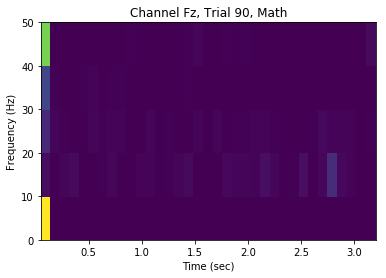

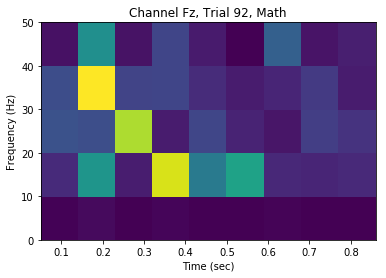

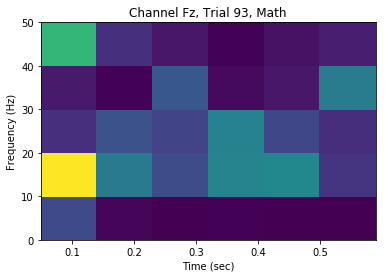

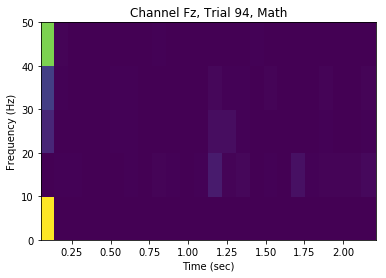

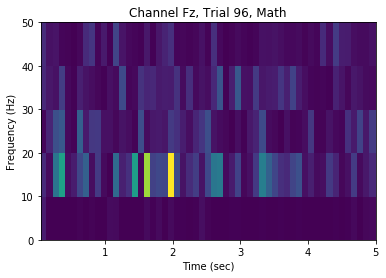

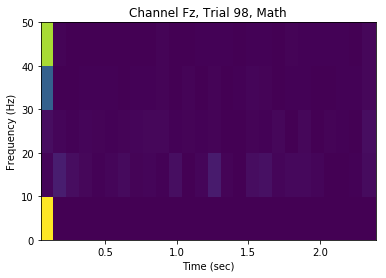

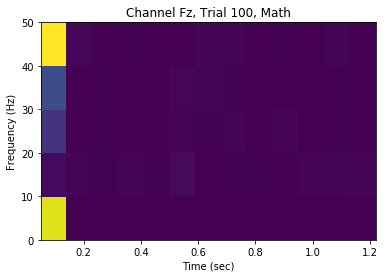

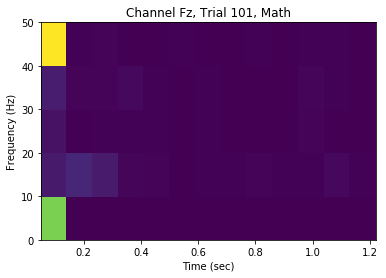

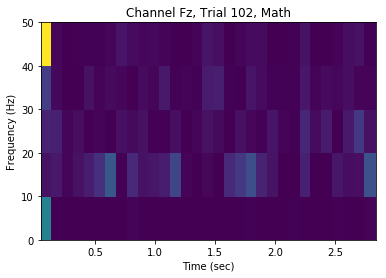

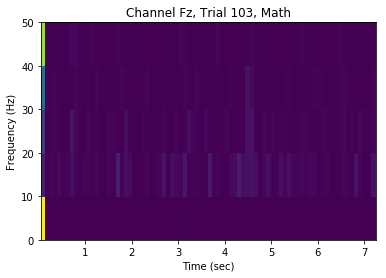

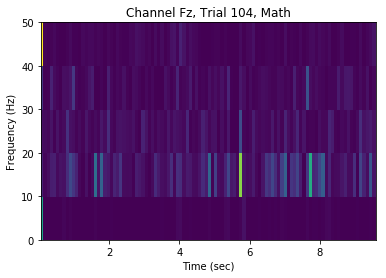

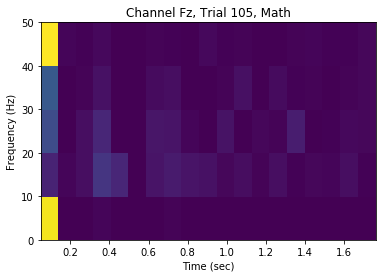

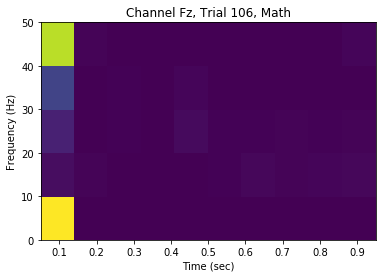

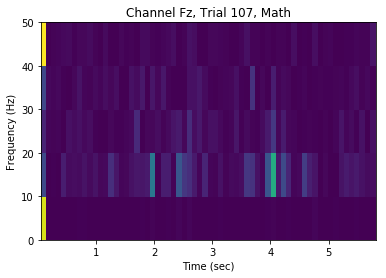

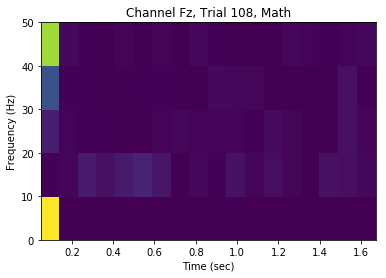

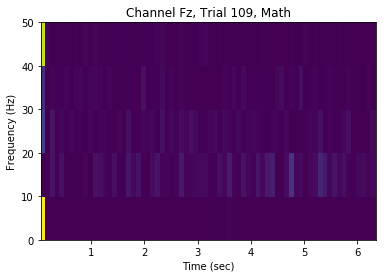

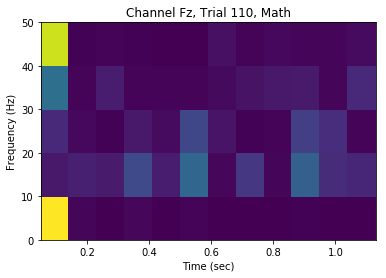

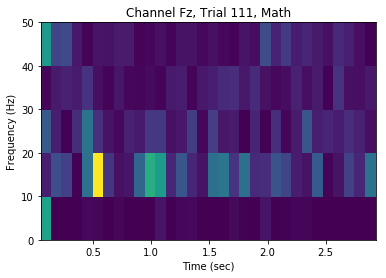

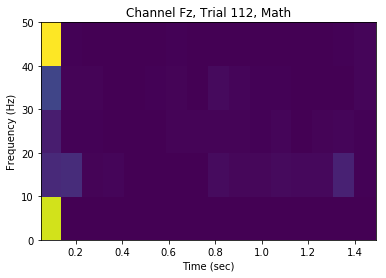

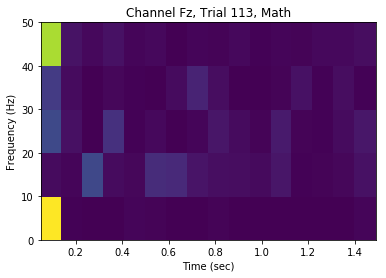

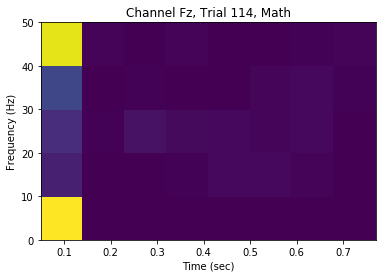

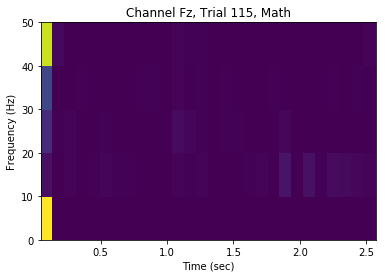

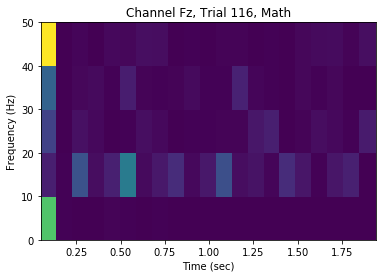

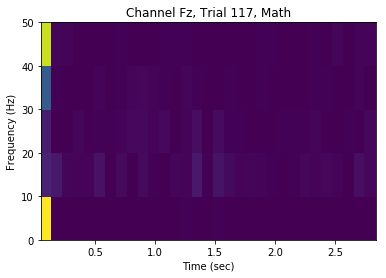

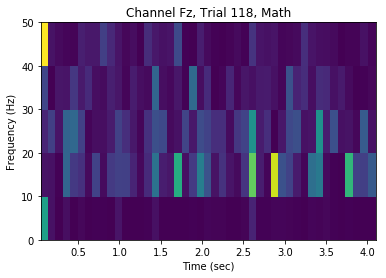

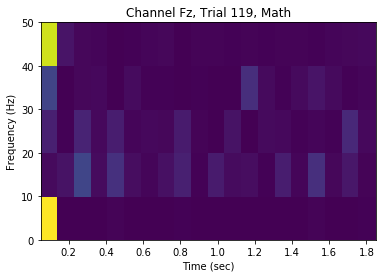

In [29]:
chanOfInt = 'Fz'
trials = np.where(np.asarray(trial_type)==1) # where trial_type = 1 = math
ds_factor = 5 # downsampling factor

for trialOfInt in trials[0]:
    f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)
    # nperseg determines size of time bins, number of time bins = fs/nperseg - 1
    # nperseg = number of segments per second, so 10 = 100 ms chunks
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title('Channel ' + chanOfInt + ', Trial ' + str(trialOfInt) + ', Math')
    plt.show()

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


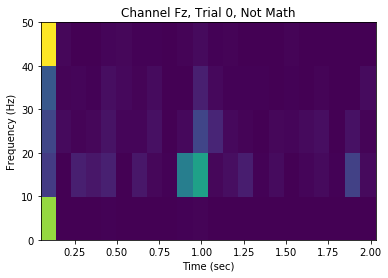

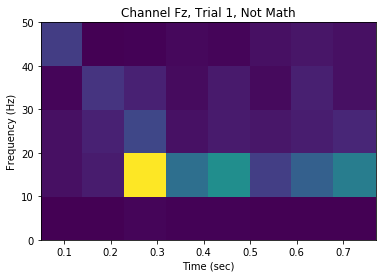

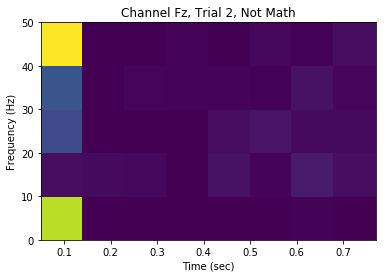

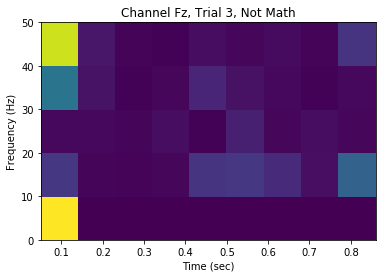

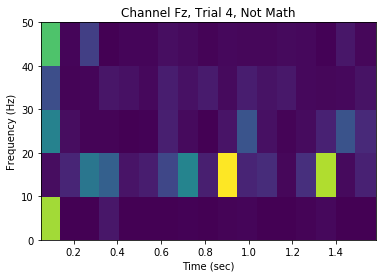

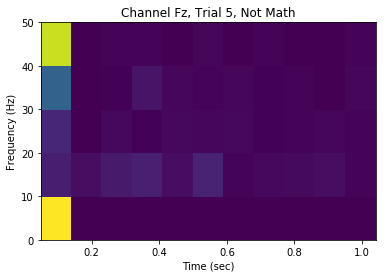

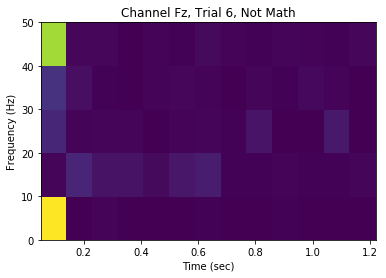

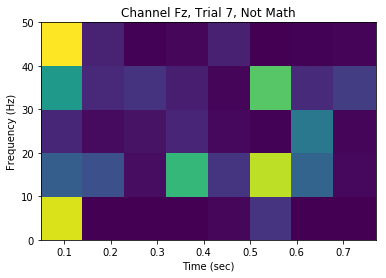

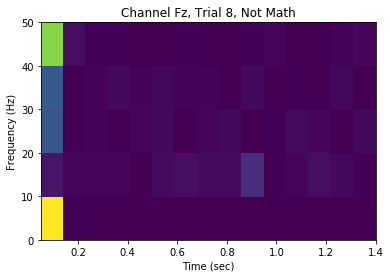

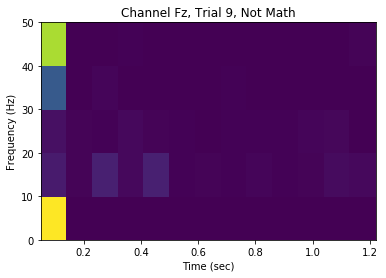

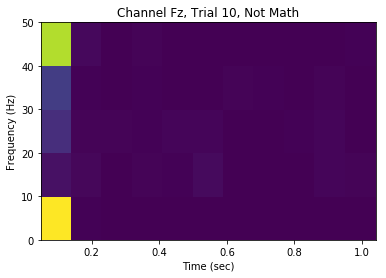

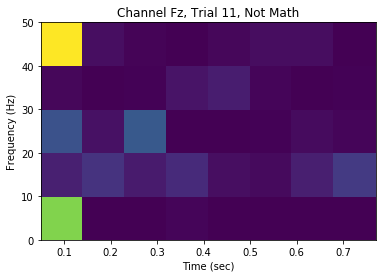

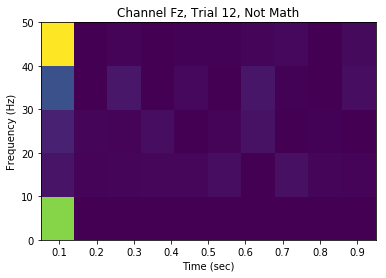

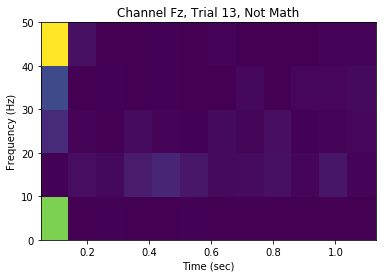

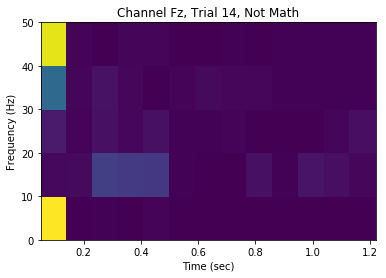

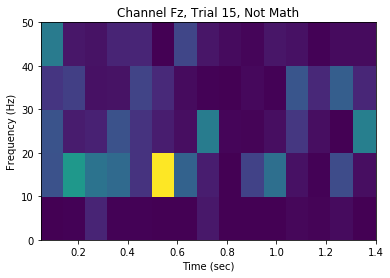

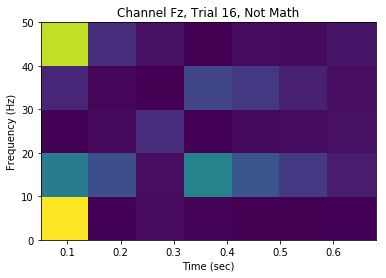

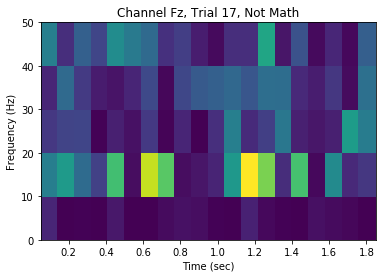

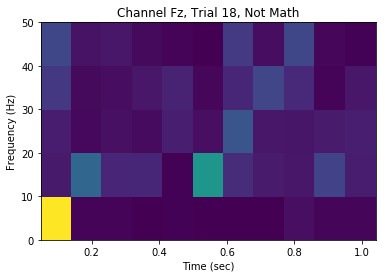

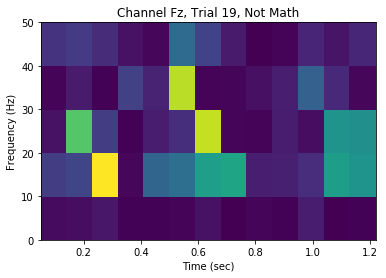

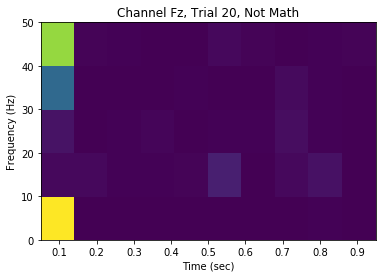

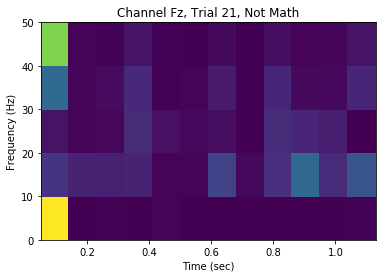

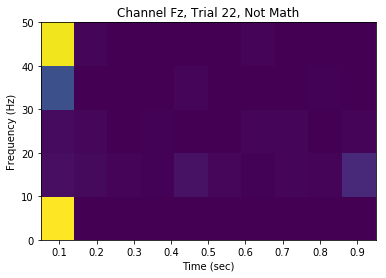

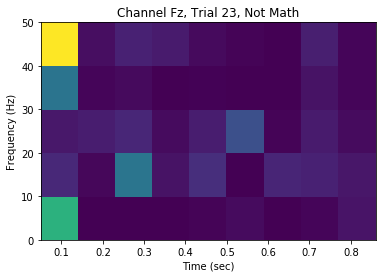

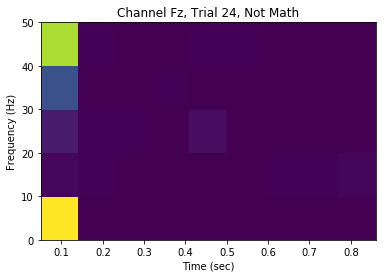

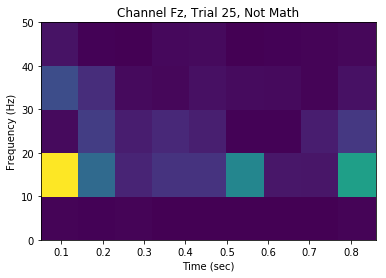

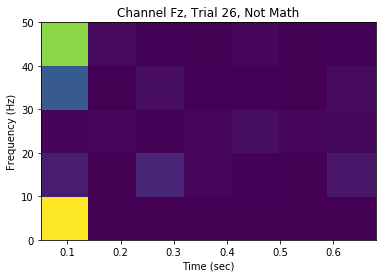

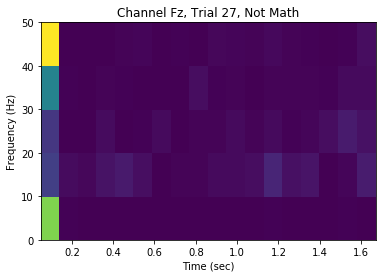

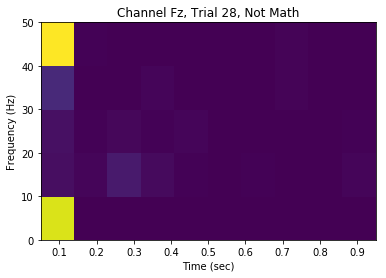

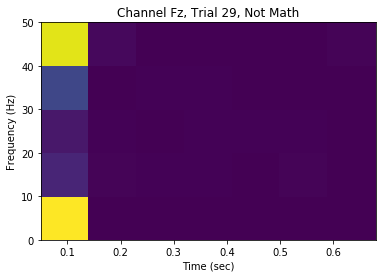

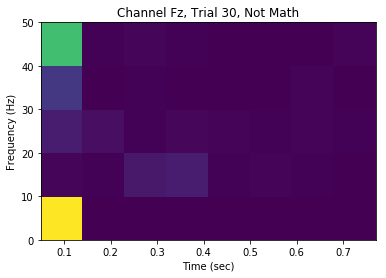

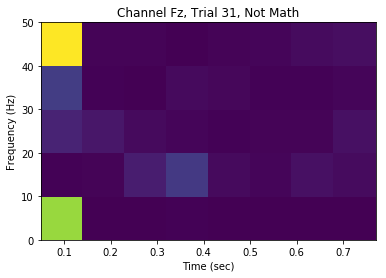

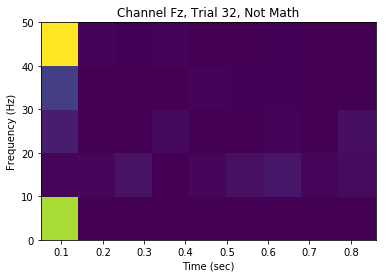

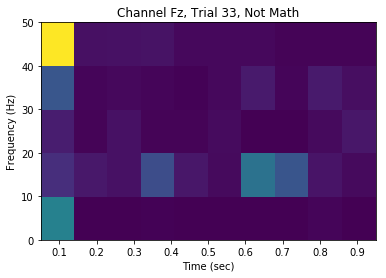

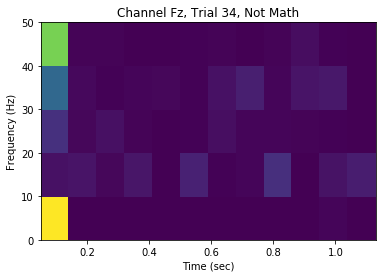

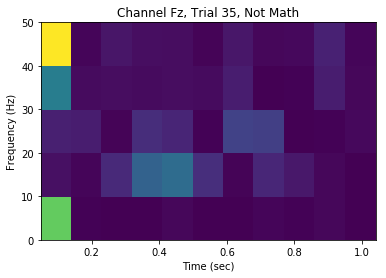

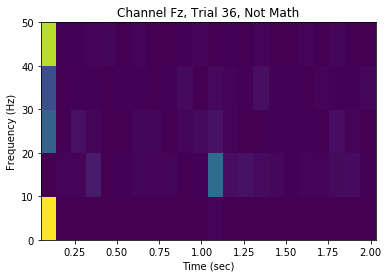

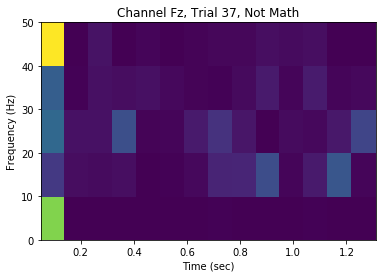

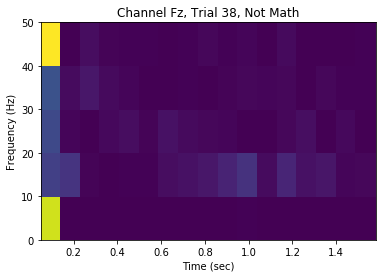

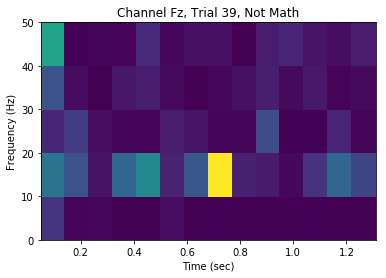

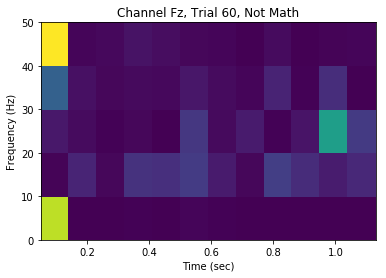

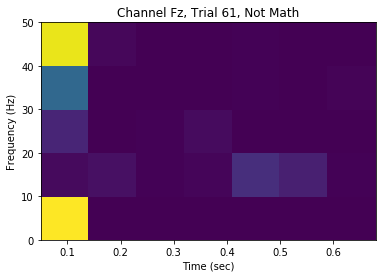

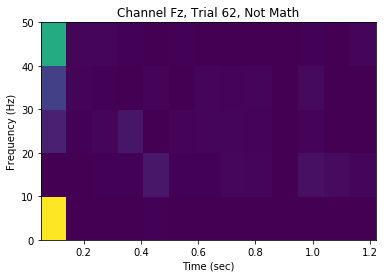

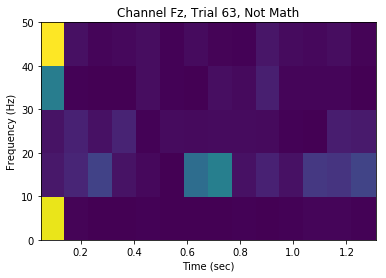

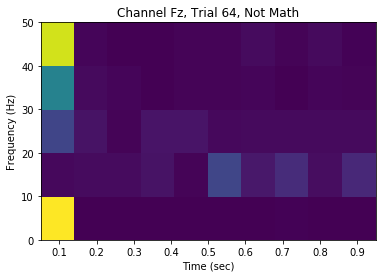

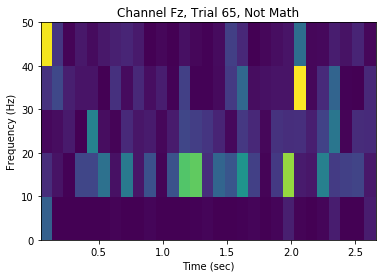

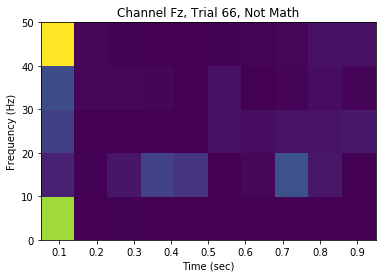

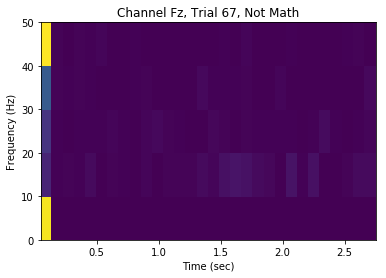

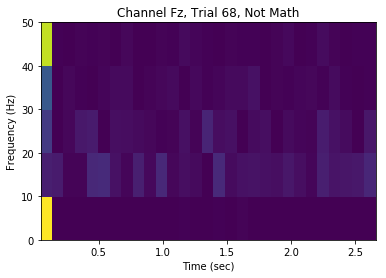

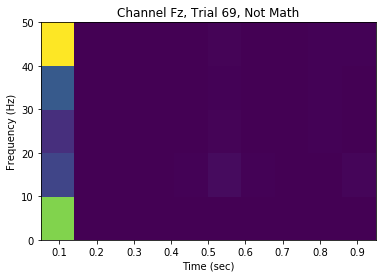

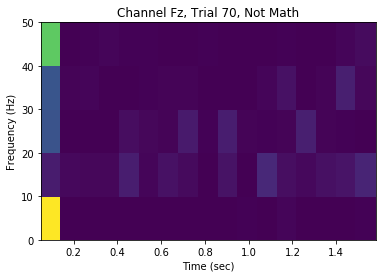

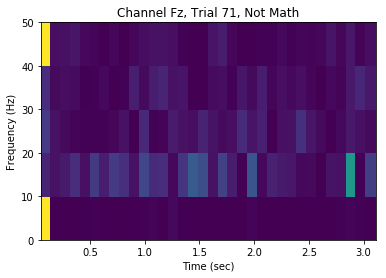

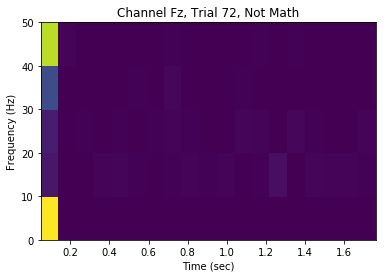

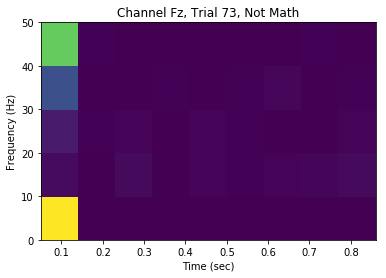

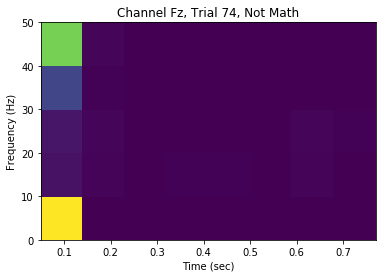

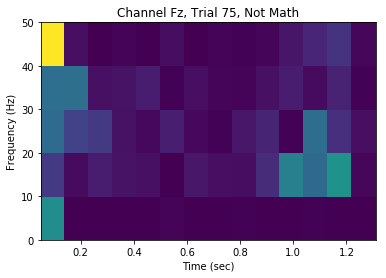

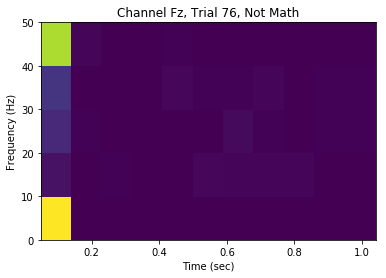

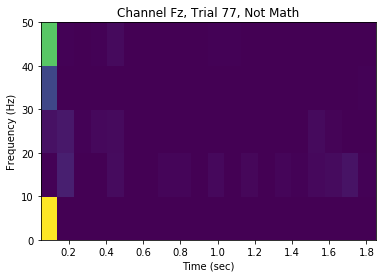

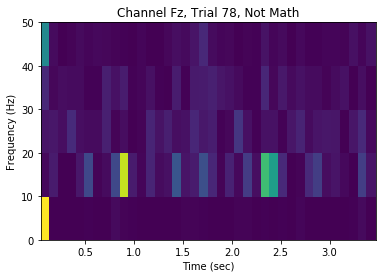

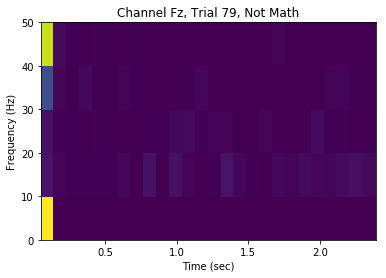

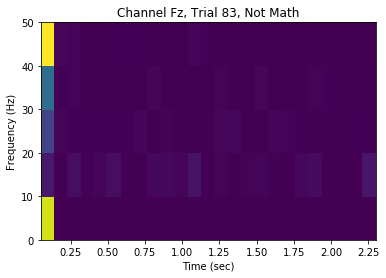

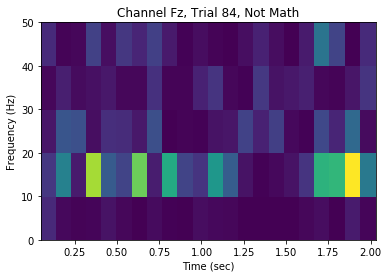

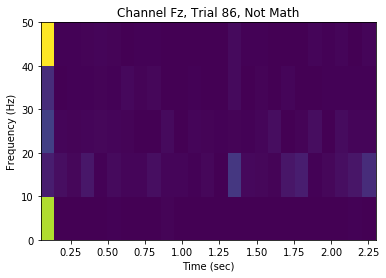

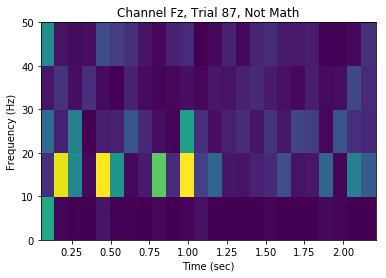

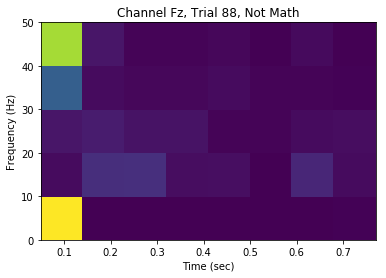

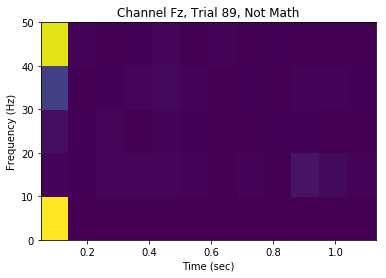

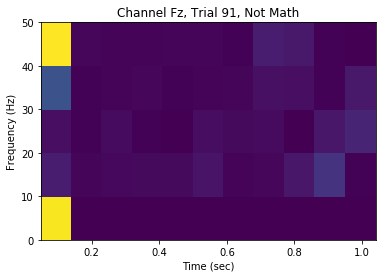

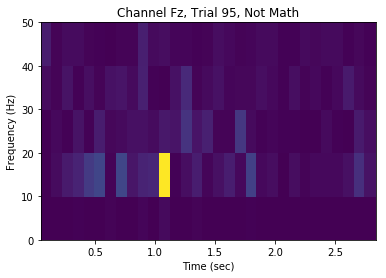

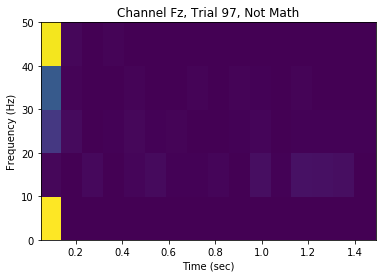

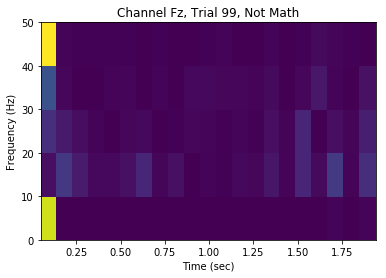

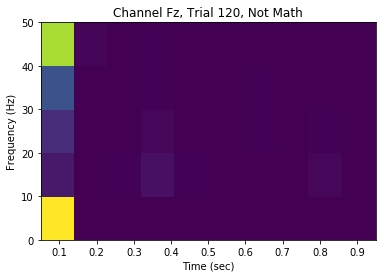

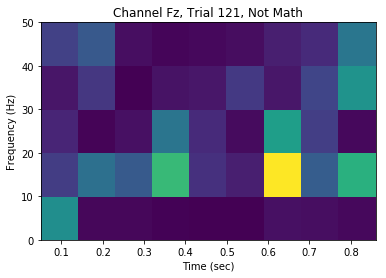

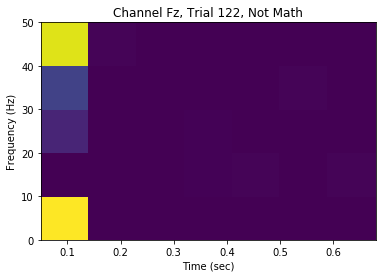

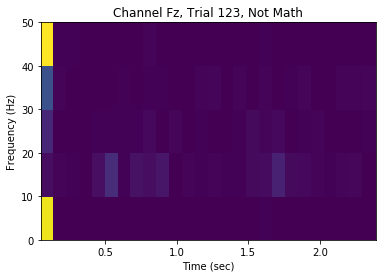

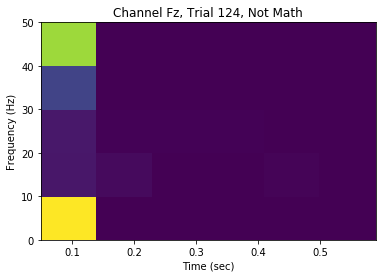

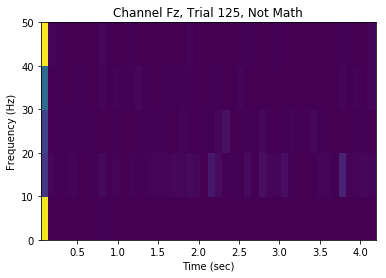

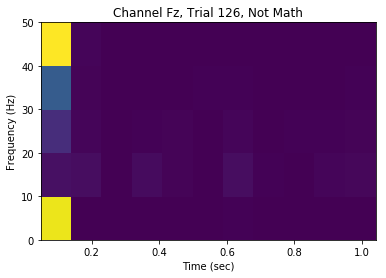

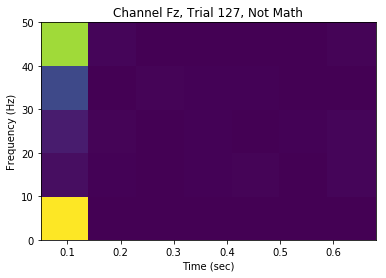

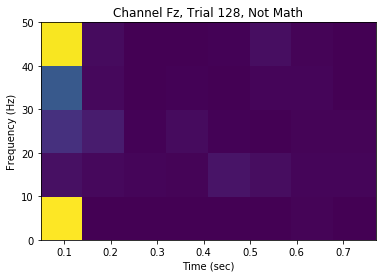

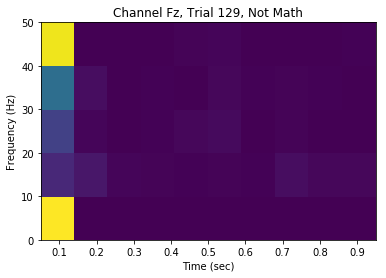

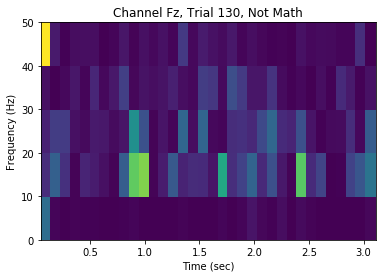

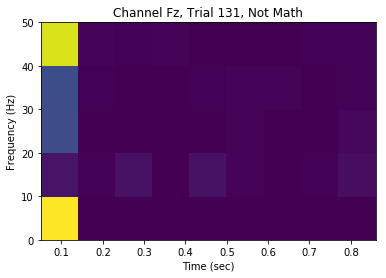

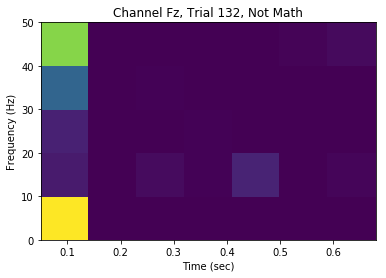

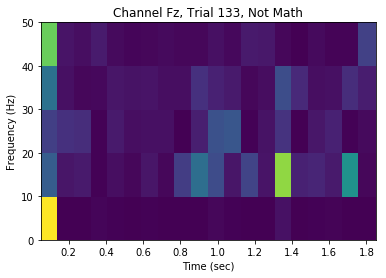

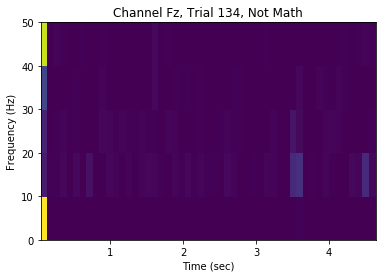

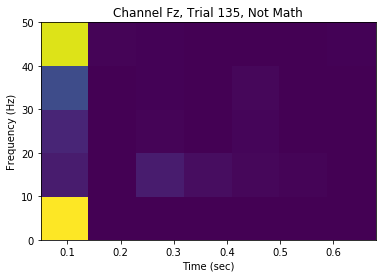

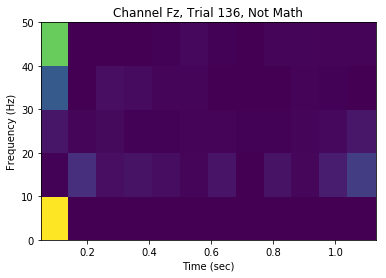

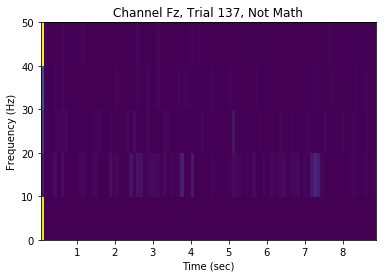

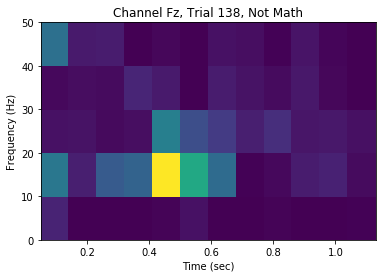

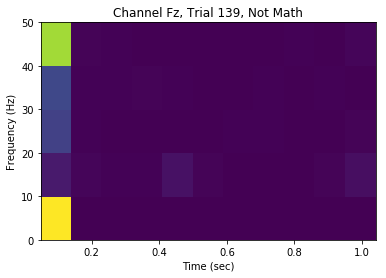

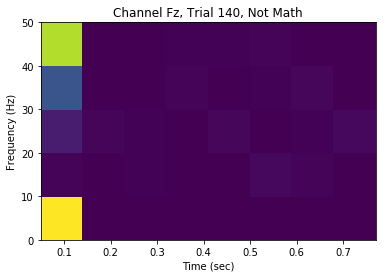

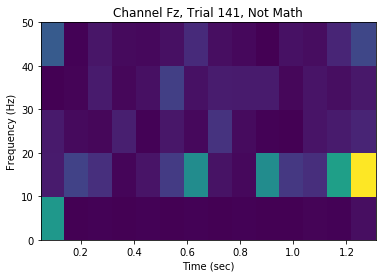

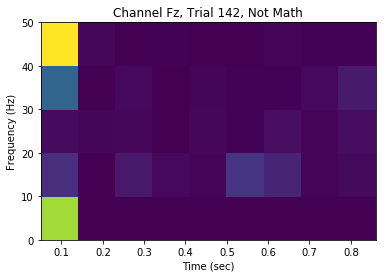

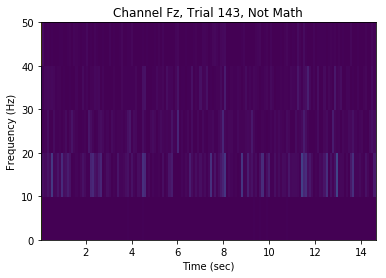

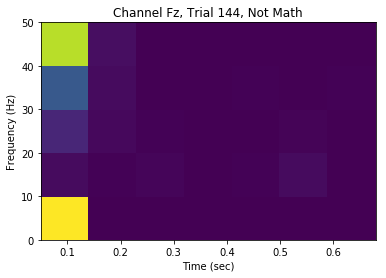

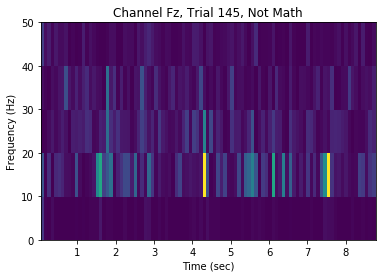

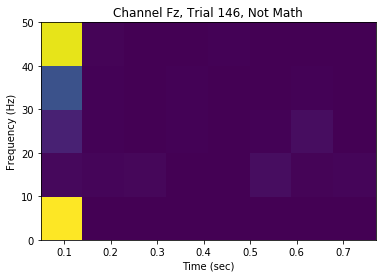

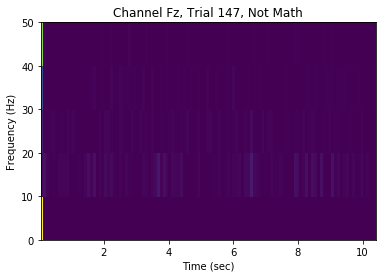

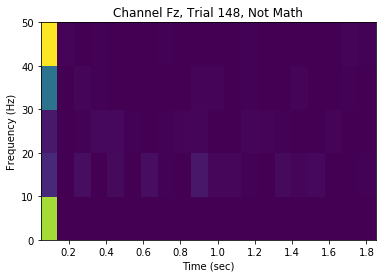

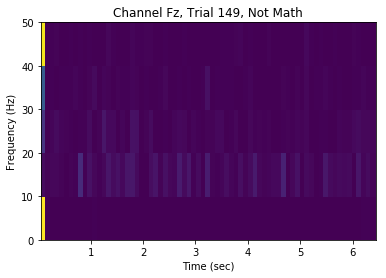

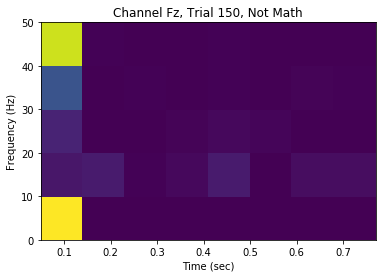

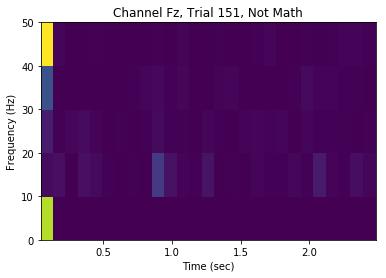

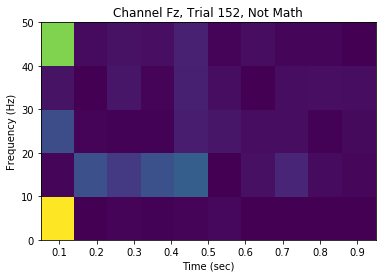

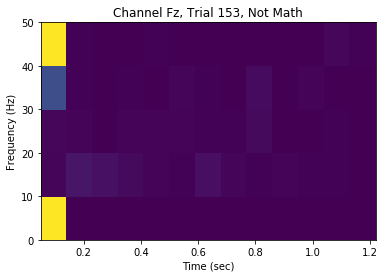

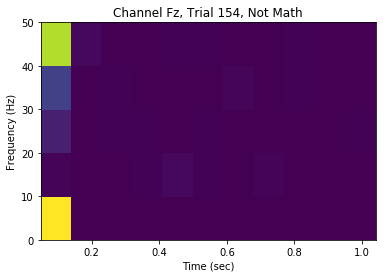

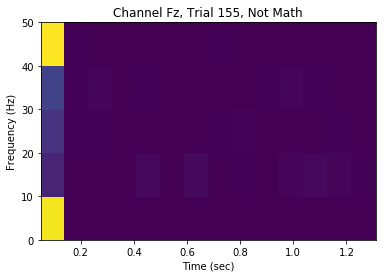

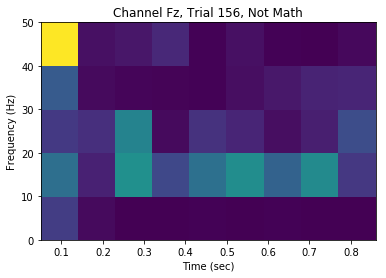

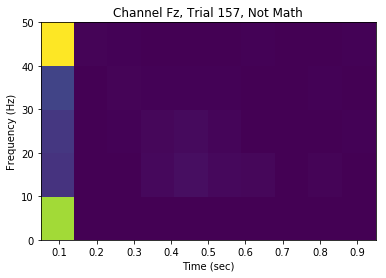

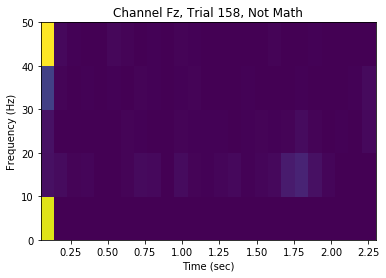

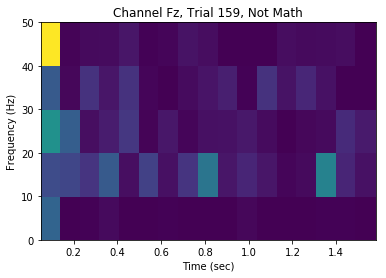

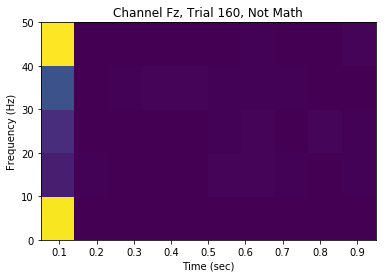

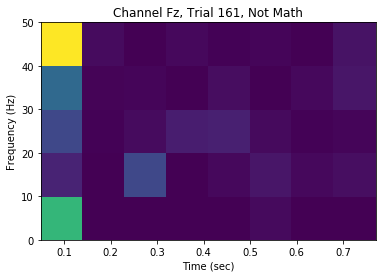

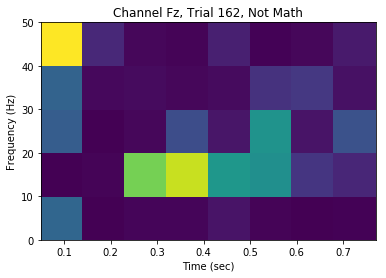

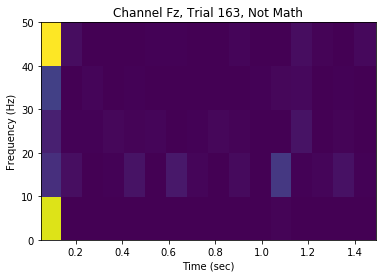

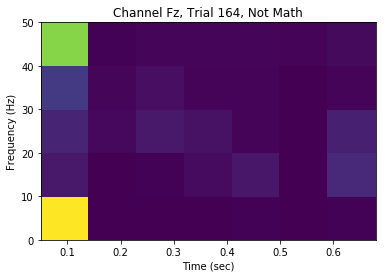

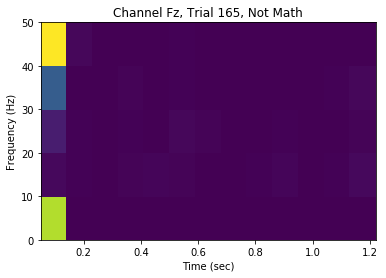

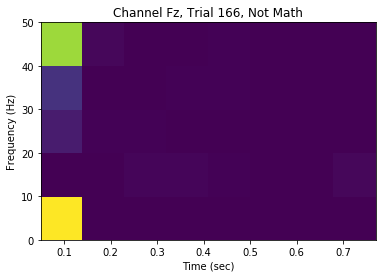

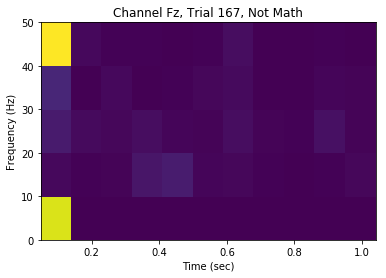

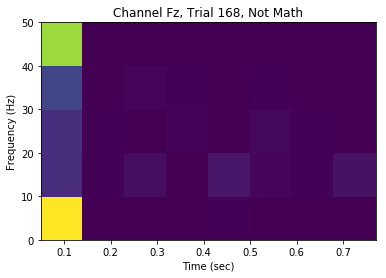

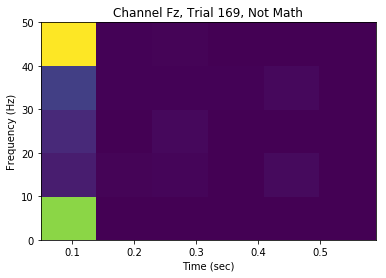

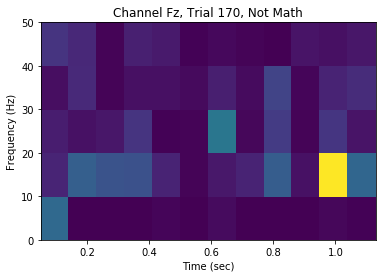

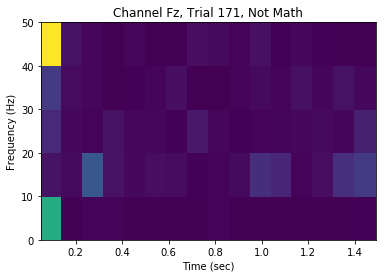

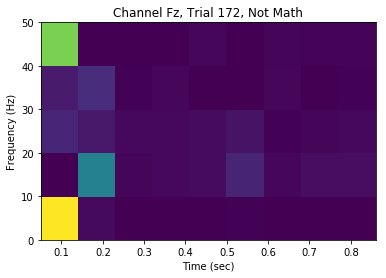

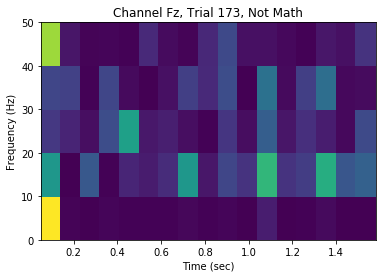

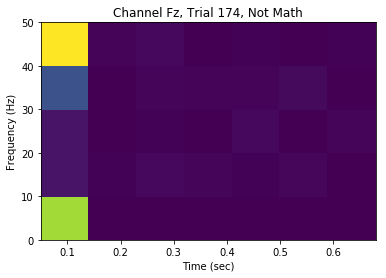

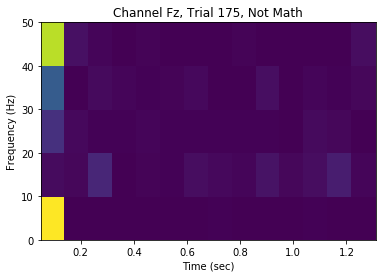

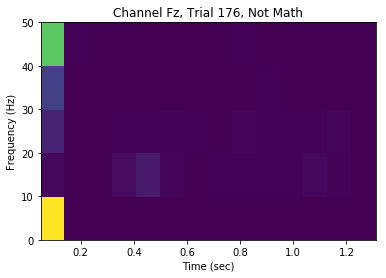

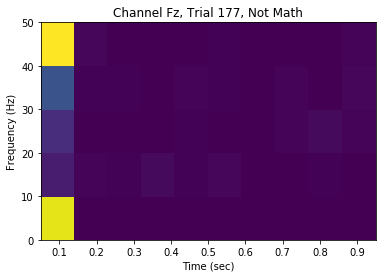

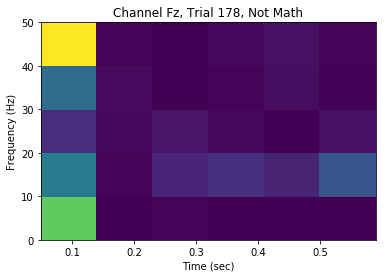

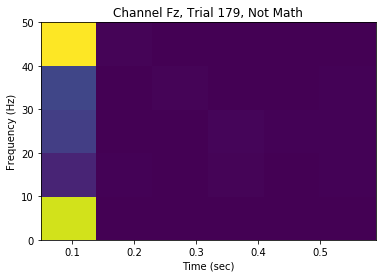

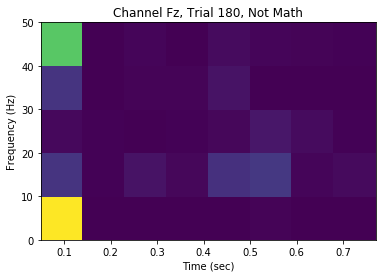

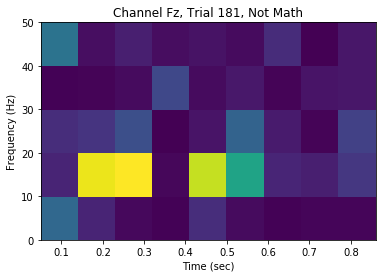

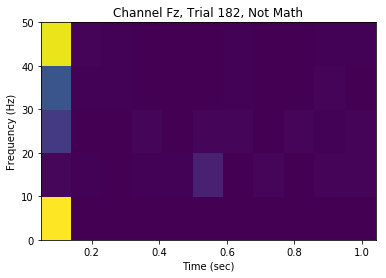

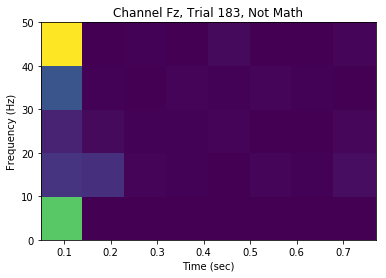

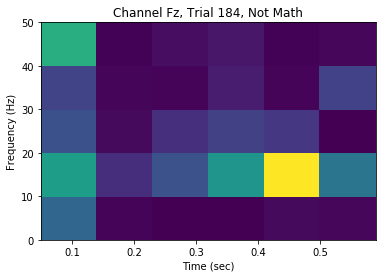

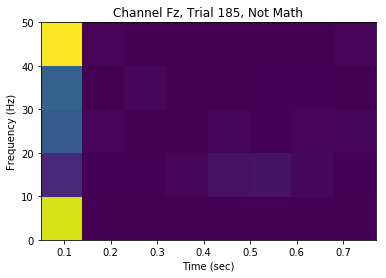

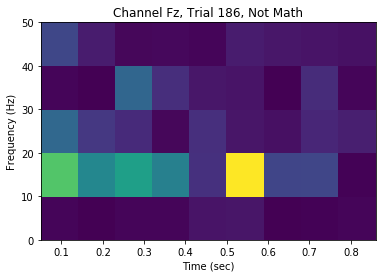

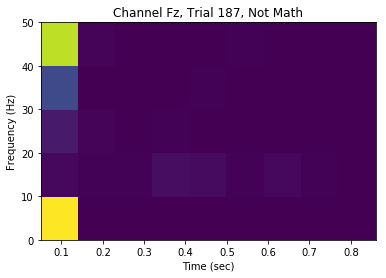

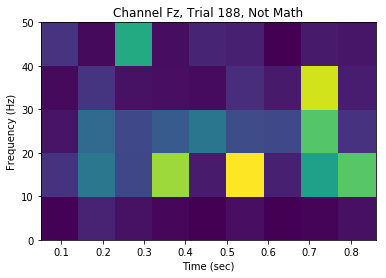

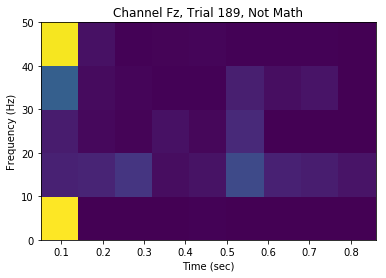

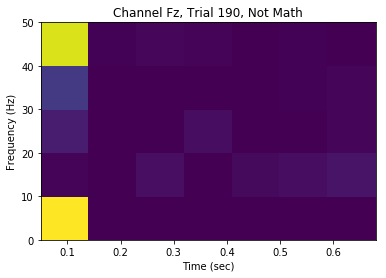

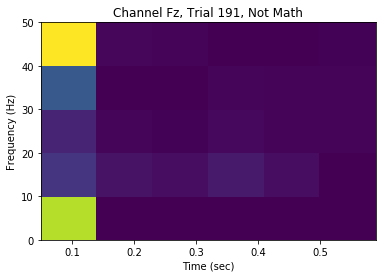

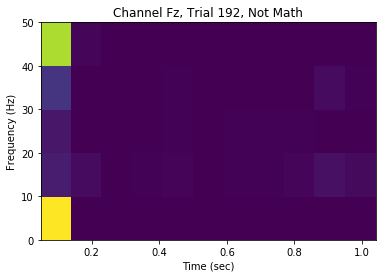

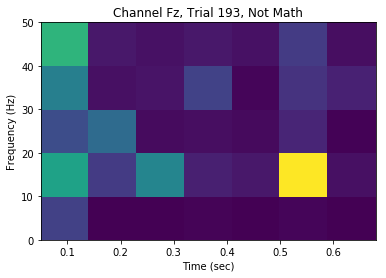

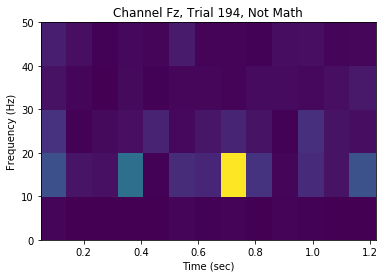

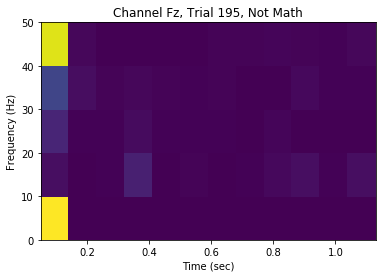

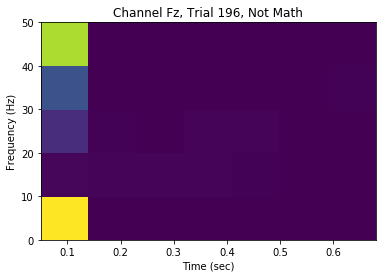

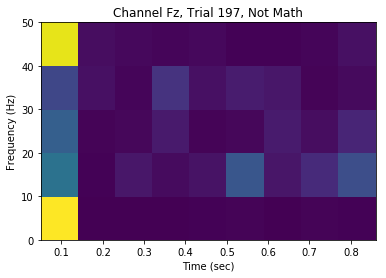

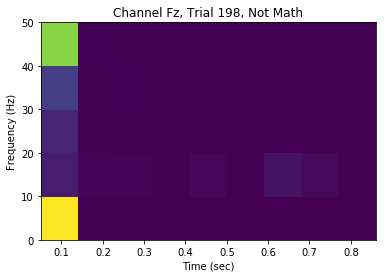

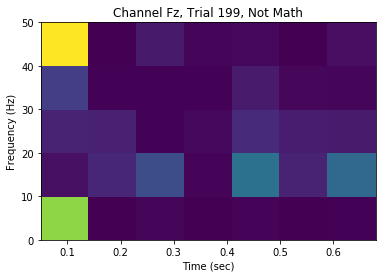

In [30]:
chanOfInt = 'Fz'
trials = np.where(np.asarray(trial_type)==0) # where trial_type = 0 = non-math
ds_factor = 5 # downsampling factor

for trialOfInt in trials[0]:
    f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)
    # nperseg determines size of time bins, number of time bins = fs/nperseg - 1
    # nperseg = number of segments per second, so 10 = 100 ms chunks
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title('Channel ' + chanOfInt + ', Trial ' + str(trialOfInt) + ', Not Math')
    plt.show()

Compare alpha and beta power of different electrodes

## Classify epochs
See if you can reliably classify math vs non-math trials (reflecting differences in DMN activity)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

Format the data to feed into a model

In [32]:
epochs_collapsed = []
time_cut_start = 0
time_cut_end = int(0.5 * fs / ds_factor)

# Cut all epochs to first 500 ms of trial, and concatenate
for i in range(0,len(epochs_raw)):
    epochs_collapsed.append(np.asarray(epochs_raw[i][time_cut_start:time_cut_end]).flatten())

In [33]:
# Double check we as many examples as we do number of trials
np.shape(epochs_collapsed)

(200, 400)

In [34]:
# Check the size of one of the trials (should be number of samples in the trial * number of channels)
np.shape(epochs_collapsed[0])

(400,)

In [69]:
# Assign your input and labels
X = epochs_collapsed
y = trial_type

# shuffle data to get train/test
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]

In [70]:
args

array([ 32,  18,  69, 170, 193,  30, 132, 151, 116,  95, 103, 141, 108,
       136,  24,  21, 182, 135, 113, 112,  83,  35, 174,  52, 188, 185,
       178,  43,  49,  54, 194, 189,  81,  77, 130, 147, 105,   6,  79,
        88,  40, 128, 184, 106,   3,  57,  26,  71,  59, 150, 140, 168,
       138,  84, 164,   9, 148, 107,  22, 114, 124,   4, 183,  16,  91,
       154,  10, 100,  15, 199, 121, 129,  61, 171,   1,  20, 163,  44,
       197,  66,  65,  48,  31,  39, 125,  55, 118, 122,  60, 160, 195,
       167, 137, 179,  23, 101,  41,  42,  33,  70,  46, 152, 120, 180,
        73,  17,  47,  90, 149,   2, 169, 119,  62,  93, 134, 133, 158,
        86, 146,  80, 177,  87,  36,  11,  27,  14, 165,  74, 196,  92,
        94, 190, 143,  58,  56,  82,  45, 187,  29,   8, 111,  63,  96,
       123, 109,  64, 166, 144,  78, 186, 127,  50, 110,  37, 142, 176,
        97, 155,  89,  12, 172, 157,  25,  99, 159, 191,  72,  76,  13,
       139, 198,  53,  67,  51, 145,  75, 102, 131,   7,   5, 15

In [71]:
# Separate into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Determine model parameters

In [72]:
Cs = [0.001, 0.01, 0.1, 1, 5, 10]
degrees = [1, 5]

In [73]:
hyper_params = {"C":Cs, "degree":degrees}

In [74]:
grid = GridSearchCV(SVC(kernel='poly', class_weight='balanced', gamma='auto'), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)

In [75]:
#grid.fit(X_train, y_train)

In [76]:
#grid.best_estimator_

Fit the model (make sure to use class_weight='balanced' because we have an uneven split of math and non-math labels)

In [77]:
svc = SVC(kernel='poly', class_weight='balanced', C=0.1, degree=1, gamma='auto', verbose=True)
svc.fit(X_train, y_train)

[LibSVM]

SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

Evaluate

In [78]:
start_ms = str(int(time_cut_start * ds_factor / fs * 1000))
end_ms = str(int(time_cut_end * ds_factor / fs * 1000))
print('Using spectrogram data from all channels from ' + start_ms + '-' + end_ms + ' ms (relative to start of trial)')
print('Training Score: ' + str(svc.score(X_train, y_train)))
print('Test Score: ' + str(svc.score(X_test, y_test)))

Using spectrogram data from all channels from 0-500 ms (relative to start of trial)
Training Score: 0.875
Test Score: 0.875


### Confusion matrix
|     .    | Predicted Pos    | Predicted Neg    |
|----------|----------------|----------------|
| Actual Pos | True Positive (TP)  | False Negative (FN) |
| Actual Neg | False Positive (FP) | True Negative (TN)  |

In [79]:
confusion_matrix(y_test, svc.predict(X_test))

array([[28,  4],
       [ 1,  7]], dtype=int64)

### Visualize principal components

In [46]:
from mpl_toolkits.mplot3d import Axes3D

In [47]:
# Run PCA
pca = PCA(n_components=3)
results = pca.fit_transform(X)

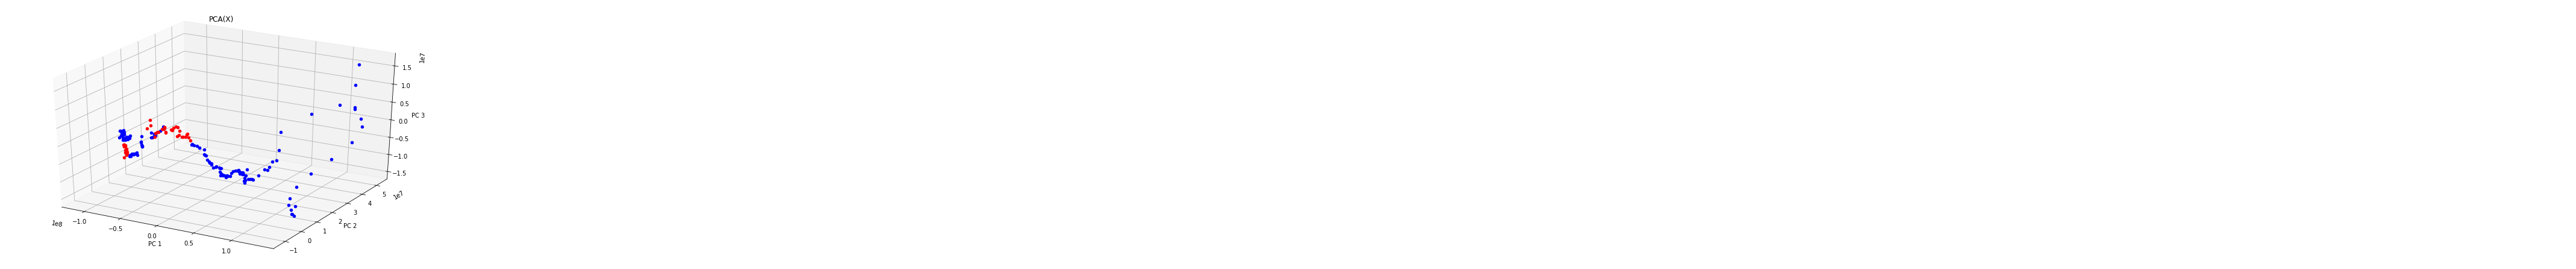

Red = Math, Blue = Non-math


In [48]:
# Plot
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
i=0
for num in y:
    # print(str(num))
    if num == 1:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='red')
    else:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='blue')
    i = i +1

ax.set_title('PCA(X)')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()
print('Red = Math, Blue = Non-math')